In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from moa.model import DenseNet, Model, DenseBlock

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

data_dir = './DATA/lish-moa/'
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data set

In [80]:
X = pd.read_csv(data_dir+'train_features.csv', index_col='sig_id')
y = pd.read_csv(data_dir+'train_targets_scored.csv', index_col='sig_id')
X_sub = pd.read_csv(data_dir+'test_features.csv', index_col='sig_id')

# One-hot encoding for cp_type and cp_dose
X['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
X['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)

X_sub['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
X_sub['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)

# # split into training set and test set
# ids = X.index.values.copy()
# np.random.shuffle(ids)
# train_perc, test_perc = 0.85, 0.15
# train_id = ids[:round(len(ids)*train_perc)]
# test_id = ids[round(len(ids)*train_perc):]
# X_train = X.loc[train_id]
# X_test = X.loc[test_id]
# y_train = y.loc[train_id]
# y_test = y.loc[test_id]
# # normalize the data
# scaler = StandardScaler()
# X_train_norm = scaler.fit_transform(X_train)
# X_test_norm = scaler.transform(X_test)

## Preprocess

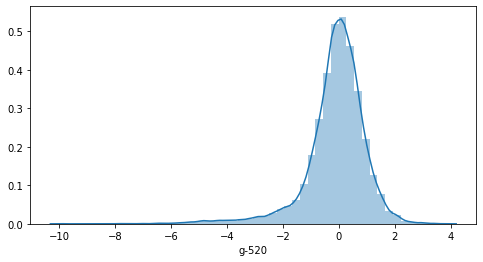

In [30]:
# before Rank Gauss
sns.distplot(X['g-520'])

In [81]:
X1 = X.copy()
X1_sub = X_sub.copy()
# Rank Gauss : transform each column to follow a normal distribution 
GENES = [col for col in X.columns if col.startswith('g-')]
CELLS = [col for col in X.columns if col.startswith('c-')]
for col in (GENES + CELLS):
    transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
    n_sample = len(X[col].values)
    n_sample_sub = len(X_sub[col].values)
    raw_vec = X[col].values.reshape(n_sample, 1)
    raw_vec_sub = X_sub[col].values.reshape(n_sample_sub, 1)
    transformer.fit(raw_vec)
    X1[col]=transformer.transform(raw_vec).reshape(1, n_sample)[0]
    X1_sub[col] = transformer.transform(raw_vec_sub).reshape(1, n_sample_sub)[0]

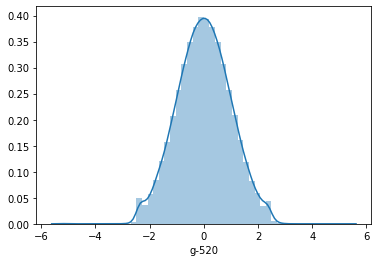

In [12]:
# after Rank Gauss
sns.distplot(X1['g-520'])

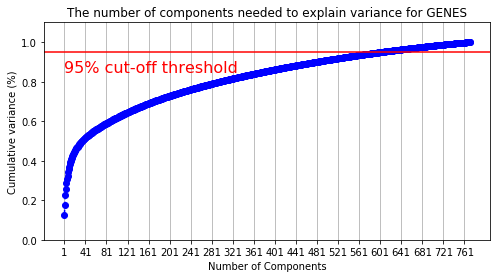

In [22]:
# number of PCA components for GENES
data = pd.concat([X1[GENES], X1_sub[GENES]])

pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (8, 4)
fig, ax = plt.subplots()
x = np.arange(1, 1+len(GENES), step=1)
y1 = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0., 1.1)
plt.plot(x, y1, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+len(GENES), step=40))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for GENES')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)
ax.grid(axis='x')

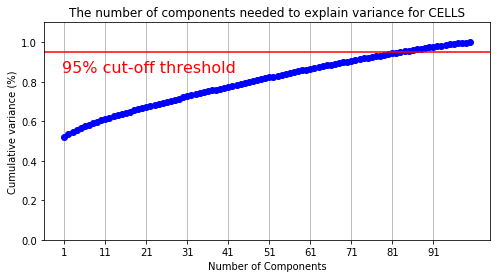

In [24]:
# number of PCA components for CELLS
data = pd.concat([X1[CELLS], X1_sub[CELLS]])

pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (8, 4)
fig, ax = plt.subplots()
x = np.arange(1, 1+len(CELLS), step=1)
y1 = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0., 1.1)
plt.plot(x, y1, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+len(CELLS), step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for CELLS')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)
ax.grid(axis='x')

In [82]:
# PCA : GENES
n_comp = 600
pca = PCA(n_components=n_comp, random_state = 42)
data = pd.concat([X1[GENES], X1_sub[GENES]])
data2 = pca.fit_transform(data)            # data leakage?
X_pca_GENES = pd.DataFrame(data2[:X1.shape[0]], columns=[f"pca_g-{i}" for i in range(n_comp)], index=X1.index)
X_pca_sub_GENES = pd.DataFrame(data2[X1.shape[0]:], columns=[f"pca_g-{i}" for i in range(n_comp)], index=X1_sub.index)

X1 = pd.concat((X1, X_pca_GENES), axis=1)
X1_sub = pd.concat((X1_sub, X_pca_sub_GENES), axis=1)

# X1 = pd.concat((X1.iloc[:,:3], X_pca_GENES), axis=1)
# X1_sub = pd.concat((X1_sub.iloc[:,:3], X_pca_sub_GENES), axis=1)

In [83]:
# PCA : CELLS
n_comp = 80
pca = PCA(n_components=n_comp, random_state = 42)
data = pd.concat([X1[CELLS], X1_sub[CELLS]])
data2 = pca.fit_transform(data)            # data leakage?
X_pca_CELLS = pd.DataFrame(data2[:X1.shape[0]], columns=[f"pca_c-{i}" for i in range(n_comp)], index=X1.index)
X_pca_sub_CELLS = pd.DataFrame(data2[X1.shape[0]:], columns=[f"pca_c-{i}" for i in range(n_comp)], index=X1_sub.index)

X1 = pd.concat((X1, X_pca_CELLS), axis=1)
X1_sub = pd.concat((X1_sub, X_pca_sub_CELLS), axis=1)

In [84]:
# feature selection using Variance Encoding
var_thresh = VarianceThreshold(0.8)      # 0.4
data = X1.append(X1_sub)
data_transformed = var_thresh.fit_transform(data.iloc[:,3:])
X_transformed = pd.DataFrame(data_transformed[:X.shape[0]], index=X.index)
X_sub_transformed = pd.DataFrame(data_transformed[X.shape[0]:], index=X_sub.index)

X1 = pd.concat((X1.iloc[:,:3], X_transformed), axis=1)
X1_sub = pd.concat((X1_sub.iloc[:,:3], X_sub_transformed), axis=1)

In [85]:
# only keep "cp_type==1"
X1 = X1[X1.cp_type == 1].drop('cp_type', axis=1)
X1_sub = X1_sub[X1_sub.cp_type == 1].drop('cp_type', axis=1)
y1 = y.loc[X1.index]

In [86]:
X.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,1.0,24,1.0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,1.0,72,1.0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,1.0,48,1.0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,1.0,48,1.0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,1.0,72,0.0,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [87]:
X.shape

(23814, 875)

In [88]:
X1.head()

,cp_time,cp_dose,0,1,2,3,4,5,6,7,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,24,1.0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,...,1.612562,4.877738,1.542488,-1.551572,1.148225,0.919497,-1.070825,-0.278425,0.104555,-0.210253
id_000779bfc,72,1.0,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,...,-0.688668,5.049432,-0.359994,0.016592,0.994139,-0.507524,0.687180,-0.272853,0.449602,-1.054052
id_000a6266a,48,1.0,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,...,-0.897952,-1.391302,0.301496,-0.297876,-0.212681,-0.094767,-0.724843,0.873353,0.033897,-1.060842
id_0015fd391,48,1.0,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,...,0.168627,-10.972282,1.160249,-0.950181,-1.579002,0.009782,-1.242427,-0.401590,0.492104,-0.351390
id_001626bd3,72,0.0,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,...,0.447416,3.599316,0.561047,-0.665226,-0.299919,0.268498,0.251956,0.296508,-0.164945,-0.554515


In [89]:
X1.shape

(21948, 1039)

In [79]:
X1_sub.shape

(3624, 1039)

In [93]:
a = y.loc[X[X.cp_type == 0].index]

In [94]:
a.shape

(1866, 206)

In [95]:
(a.values==1).sum()

0

In [91]:
a = list(X_sub.index)

In [92]:
sorted(a) == a

True

In [96]:
21948/23814

0.9216427311665407

## Model

In [6]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

params_net = {'input_size': X_train_norm.shape[1],
             'hidden_size': [1024, 512, 1024],
             'output_size': y_train.shape[1],
             'dropout': 0.01}

params_fit = {'X':X_train_norm,
             'y': y_train.values,
             'epoch': 20,
             'lr': 5e-4,
             'batch_size':128,
             'L1': 1e-6,
             'L2': 1e-6,
             'pos_weight':1,
             'patience':3,
             'verbose':True}

net = DenseNet(**params_net)
model = Model(net)
model.fit(**params_fit)

Epoch [1, 40] : train loss 0.664790689945221
Epoch [1, 80] : train loss 0.3260881006717682
Epoch [1, 120] : train loss 0.11969415843486786
Validation loss decreased (inf --> 0.094926).  Saving model ...
Epoch [2, 40] : train loss 0.07218655198812485
Epoch [2, 80] : train loss 0.06190790235996246
Epoch [2, 120] : train loss 0.05546260625123978
Validation loss decreased (0.094926 --> 0.055502).  Saving model ...
Epoch [3, 40] : train loss 0.052423469722270966
Epoch [3, 80] : train loss 0.04857975244522095
Epoch [3, 120] : train loss 0.043507568538188934
Validation loss decreased (0.055502 --> 0.045653).  Saving model ...
Epoch [4, 40] : train loss 0.04390174150466919
Epoch [4, 80] : train loss 0.04150206595659256
Epoch [4, 120] : train loss 0.038098178803920746
Validation loss decreased (0.045653 --> 0.040559).  Saving model ...
Epoch [5, 40] : train loss 0.03927799314260483
Epoch [5, 80] : train loss 0.03765852004289627
Epoch [5, 120] : train loss 0.03522629290819168
Validation loss dec

In [ ]:
n_SEED = 1
n_fold = 5
kfold = KFold(n_splits=n_fold, shuffle=True)
train_loss = []
test_loss = []
for SEED in range(100, 100+n_SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    for n, (train_idx, test_idx) in enumerate(kfold.split(X)):
        X_train = X.iloc[train_idx].values
        X_test = X.iloc[test_idx].values
        y_train = y.iloc[train_idx].values
        y_test = y.iloc[test_idx].values
        # normalize the data
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)

        params_net = {'input_size': X_train_norm.shape[1],
                     'hidden_size': [2048,2048], # 128, 4096
                     'output_size': y_train.shape[1],
                     'dropout': [0.05, 0.3, 0.2]} # 长度比hidden_size长度多1

        params_fit = {'X':X_train_norm,
                     'y': y_train,
                     'epoch': 100,
                     'lr': 1e-4, # 1e-4 ~ 1e-3
                     'batch_size':64, # 64, 128, 256, 512
                     'L1': 1e-6,
                     'L2': 1e-5,
                     'pos_weight':1,
                     'patience':5,
                     'verbose':False}
        net = DenseNet(**params_net)
        model = Model(net)
        model.fit(**params_fit)
        y_train_pred = model.predict_proba(X_train_norm)
        y_test_pred = model.predict_proba(X_test_norm)
        train_loss.append(log_loss(y_train.ravel(), y_train_pred.ravel()))
        test_loss.append(log_loss(y_test.ravel(), y_test_pred.ravel()))
        print(f"SEED {SEED-99} out of {n_SEED}, KFOLD {n+1} out of {n_fold}")

print('Training loss : ', np.average(np.array(train_loss)))
print('Test loss : ', np.average(np.array(test_loss)))

EarlyStopping counter: 1 out of 5
